In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets as dt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread, imshow

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from matplotlib.cbook import flatten

In [2]:
df_1 = pd.read_csv("/Users/henilvedant/Desktop/FashionMnist.csv")
df_1.head()

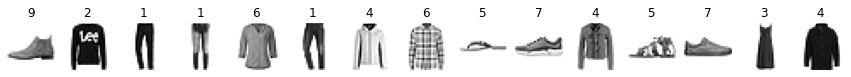

In [3]:
fig1, ax1 = plt.subplots(1,15, figsize=(15,10))
for i in range(15):
    ax1[i].imshow(X_test[i].reshape((28,28)), cmap="gray_r")
    ax1[i].axis('off')
    ax1[i].set_title(y_test[i])

In [10]:
class Attack:

    def __init__(self, model):
        self.fooling_targets = None
        self.model = model

    
    def prepare(self, X_train, y_train, X_test, y_test):
        self.images = X_test
        self.true_targets = y_test
        self.num_samples = X_test.shape[0]
        self.train(X_train, y_train)
        print("Model training finished.")
        self.test(X_test, y_test)
        print("Model testing finished. Initial accuracy score: " + str(self.initial_score))
    
    def set_fooling_targets(self, fooling_targets):
        self.fooling_targets = fooling_targets
    
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.weights = self.model.coef_
        self.num_classes = self.weights.shape[0]

    def test(self, X_test, y_test):
        self.preds = self.model.predict(X_test)
        self.preds_proba = self.model.predict_proba(X_test)
        self.initial_score = accuracy_score(y_test, self.preds)
    
   
            
    def attack(self, attackmethod, epsilon):
        perturbed_images, highest_epsilon = self.perturb_images(epsilon, attackmethod)
        perturbed_preds = self.model.predict(perturbed_images)
        score = accuracy_score(self.true_targets, perturbed_preds)
        return perturbed_images, perturbed_preds, score, highest_epsilon
    
    def perturb_images(self, epsilon, gradient_method):
        perturbed = np.zeros(self.images.shape)
        max_perturbations = []
        for n in range(self.images.shape[0]):
            perturbation = self.get_perturbation(epsilon, gradient_method, self.one_hot_targets[n], self.preds_proba[n])
            perturbed[n] = self.images[n] + perturbation
            max_perturbations.append(np.max(perturbation))
        highest_epsilon = np.max(np.array(max_perturbations))
        return perturbed, highest_epsilon
    
    def get_perturbation(self, epsilon, gradient_method, target, pred_proba):
        gradient = gradient_method(target, pred_proba, self.weights)
        inf_norm = np.max(gradient)
        perturbation = epsilon/inf_norm * gradient
        return perturbation
    
     def create_one_hot_targets(self, targets):
        self.one_hot_targets = np.zeros(self.preds_proba.shape)
        for n in range(targets.shape[0]):
            self.one_hot_targets[n, targets[n]] = 1
            
    def attack_to_max_epsilon(self, attackmethod, max_epsilon):
        self.max_epsilon = max_epsilon
        self.scores = []
        self.epsilons = []
        self.perturbed_images_per_epsilon = []
        self.perturbed_outputs_per_epsilon = []
        for epsilon in range(0, self.max_epsilon):
            perturbed_images, perturbed_preds, score, highest_epsilon = self.attack(attackmethod, epsilon)
            self.epsilons.append(highest_epsilon)
            self.scores.append(score)
            self.perturbed_images_per_epsilon.append(perturbed_images)
            self.perturbed_outputs_per_epsilon.append(perturbed_preds)

In [11]:
def calc_output_weighted_weights(output, w):
    for c in range(len(output)):
        if c == 0:
            weighted_weights = output[c] * w[c]
        else:
            weighted_weights += output[c] * w[c]
    return weighted_weights

def targeted_gradient(foolingtarget, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(output)):
        if k == 0:
            gradient = foolingtarget[k] * (w[k]-ww)
        else:
            gradient ** tree-ensemble + fooling targeted_gradient
            
            foolingtarget[k] * (w[k]-ww)
            
    return gradient

def non_targeted_gradient(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        
        if k == 0:
            gradient = (1-target[k]) * (w[k]-ww)
        else:
            gradient += (1-target[k]) * (w[k]-ww)
    return gradient

def non_targeted_sign_gradient(target, output, w):
    gradient = non_targeted_gradient(target, output, w)
    return np.sign(gradient)

In [12]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', fit_intercept=False)
 ww = calc_output_weighted_weights(output, w)

In [13]:
attack = Attack(model) 
attack.prepare(X_train, y_train, X_test, y_test)

Model training finished.
Model testing finished. Initial accuracy score: 0.841


In [14]:
weights = attack.weights
weights.shape

(10, 784)

In [15]:
num_classes = len(np.unique(y_train))
num_classes

10

In [18]:
eps = 16
attack.epsilons[eps] + non_targeted_gradient(target, output, w)

16.0

In [19]:
example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]

In [20]:
example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values
example_results.head()

,y_true,y_fooled,y_predicted,id
0,9,5,9,0
1,2,6,2,1
2,1,1,1,2
3,1,1,1,3
4,6,0,6,4


In [21]:
success_df = example_results[example_results.y_fooled != example_results.y_true]
success_df.head()

,y_true,y_fooled,y_predicted,id
0,9,5,9,0
1,2,6,2,1
4,6,0,6,4
7,6,4,6,7
8,5,7,5,8


In [22]:
example_id = success_df.id.values[0]
example_id

0

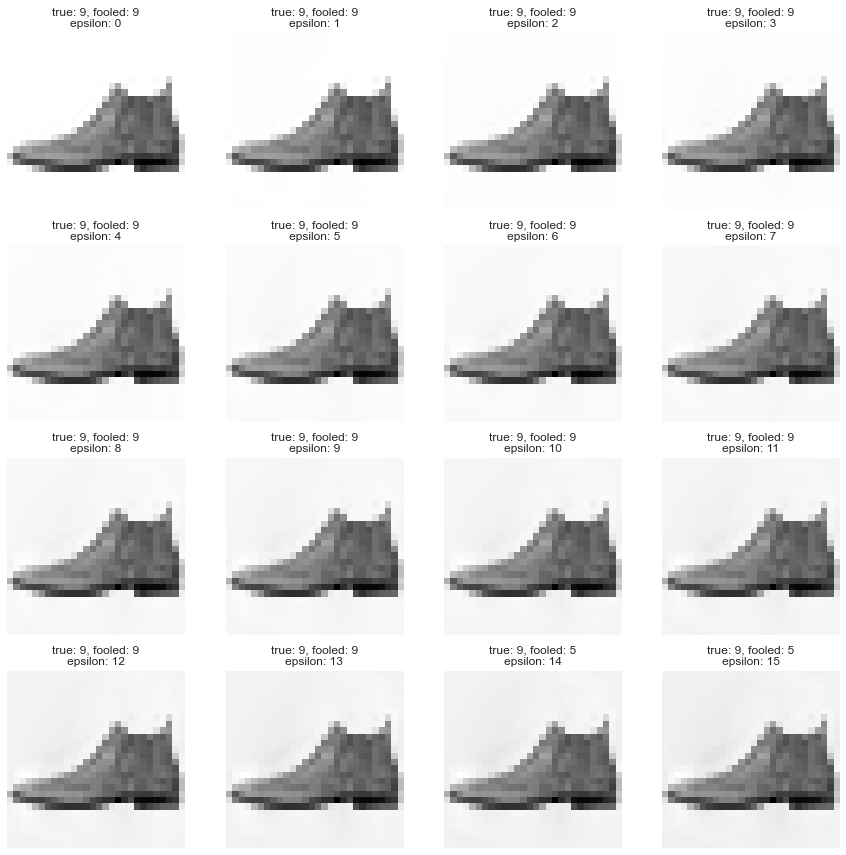

In [23]:
fig2, ax2 = plt.subplots(4,4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        image = attack.perturbed_images_per_epsilon[i*4 + j][example_id]
        y_fooled = attack.perturbed_outputs_per_epsilon[i*4 + j][example_id]
        epsilon = attack.epsilons[i*4 +j]
        ax2[i,j].imshow(image.reshape((28,28)), cmap="gray_r")
        ax2[i,j].axis('off')
        ax2[i,j].set_title("true: " + str(y_test[example_id]) + ", fooled: " + str(y_fooled)  + "\n" 
                           + "epsilon: " + str(np.int(epsilon)))

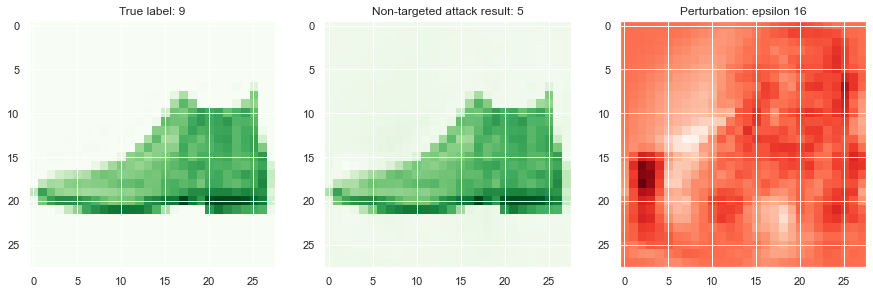

In [24]:
fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15,5))
axB.imshow(example_images[example_id].reshape((28,28)), cmap='Greens')
axB.set_title("Non-targeted attack result: " + str(example_preds[example_id]))
axA.imshow(X_test[example_id].reshape((28,28)), cmap='Greens')
axA.set_title("True label: " + str(y_test[example_id]))
axC.imshow((X_test[example_id]-example_images[example_id]).reshape((28,28)), cmap='Reds')
axC.set_title("Perturbation: epsilon 16");

 def create_one_hot_targets(self, targets):
        self.one_hot_targets = np.zeros(self.preds_proba.shape)
        for n in range(targets.shape[0]):
            self.one_hot_targets[n, targets[n]] = 1
            


<AxesSubplot:xlabel='y_fooled', ylabel='count'>

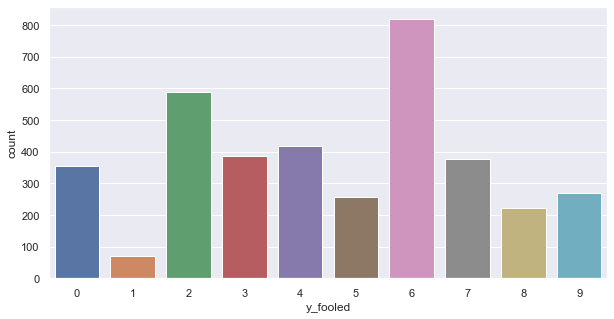

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_fooled', data=example_results[example_results.y_true != example_results.y_fooled])

In [26]:
wrong_predictions = example_results[example_results.y_true != example_results.y_predicted]
wrong_predictions.shape

(1590, 4)

In [27]:
X_test.shape

(10000, 784)

<AxesSubplot:xlabel='y_predicted', ylabel='count'>

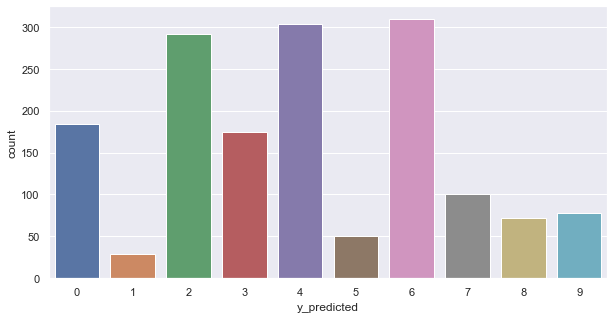

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_predicted', data=wrong_predictions)

<AxesSubplot:xlabel='y_true', ylabel='count'>

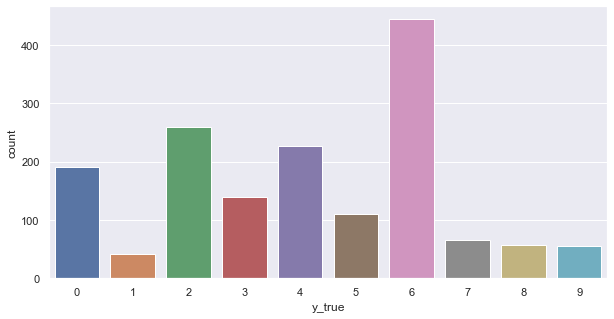

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_true', data=wrong_predictions)

In [30]:
attacktargets = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.value_counts()
counts = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.count()
attacktargets = attacktargets/counts * 100
attacktargets = attacktargets.unstack()
attacktargets = attacktargets.fillna(0.0) 
attacktargets = attacktargets.apply(np.round).astype(np.int)

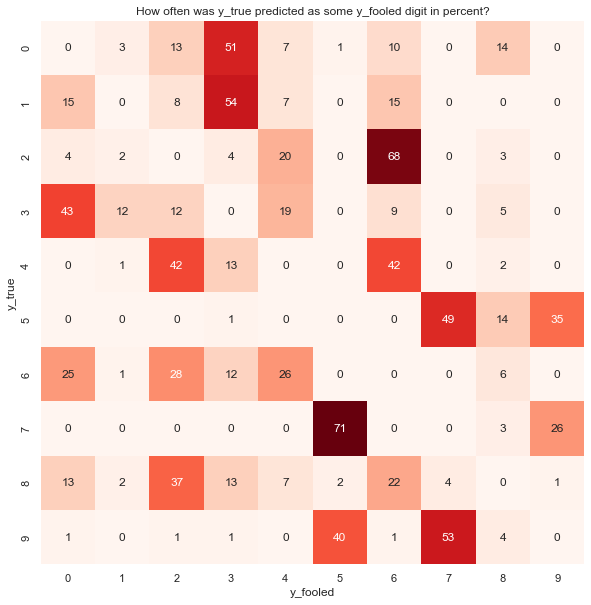

In [31]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(attacktargets, annot=True, ax=ax, cbar=False, square=True, cmap="Reds", fmt="g");
ax.set_title("How often was y_true predicted as some y_fooled digit in percent?");

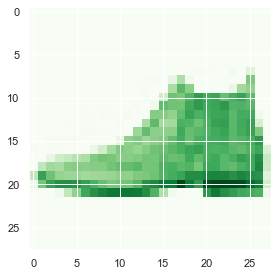

In [32]:
example = X_test[0]
imshow(example.reshape((28,28)), cmap='Greens');

In [33]:
print("true label target: " + str(y_test[0]))

true label target: 9


In [34]:
fooling_classes = []
for k in range(num_classes):
    if k != y_test[0]:
        fooling_classes.append(k)
fooling_classes

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [35]:
foolingtargets = np.zeros((len(fooling_classes), num_classes))
for n in range(len(fooling_classes)):
    foolingtargets[n,fooling_classes[n]] = 1
foolingtargets

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [36]:
eps=128
targeted_perturbed_images = []
targeted_perturbed_predictions = []
for fooling_target in foolingtargets:   
    targeted_perturbation = attack.get_perturbation(eps, targeted_gradient, fooling_target, attack.preds_proba[0])
    targeted_perturbed_image = X_test[0]+ targeted_perturbation
    targeted_perturbed_prediction = attack.model.predict(targeted_perturbed_image.reshape(1, -1))
    targeted_perturbed_images.append(targeted_perturbed_image)
    targeted_perturbed_predictions.append(targeted_perturbed_prediction)

In [37]:
targeted_perturbed_predictions

[array([0], dtype=uint8),
 array([1], dtype=uint8),
 array([2], dtype=uint8),
 array([3], dtype=uint8),
 array([4], dtype=uint8),
 array([5], dtype=uint8),
 array([6], dtype=uint8),
 array([7], dtype=uint8),
 array([8], dtype=uint8)]

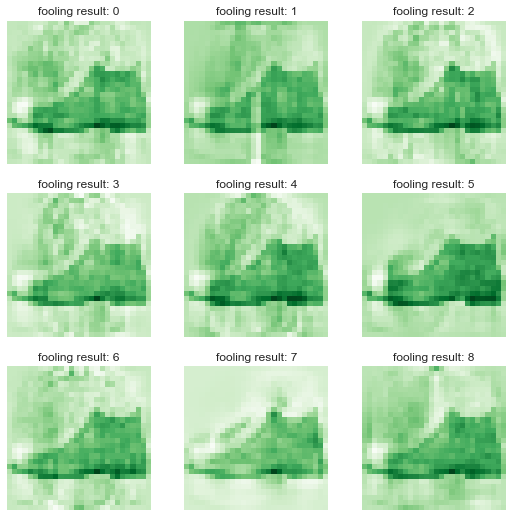

In [38]:
fig3, ax3 = plt.subplots(3,3, figsize=(9,9))
for i in range(3):
    for j in range(3):
        ax3[i,j].imshow(targeted_perturbed_images[i*3+j].reshape((28,28)), cmap="Greens")
        ax3[i,j].axis('off')
        ax3[i,j].set_title("fooling result: " + str(targeted_perturbed_predictions[i*3+j][0]))

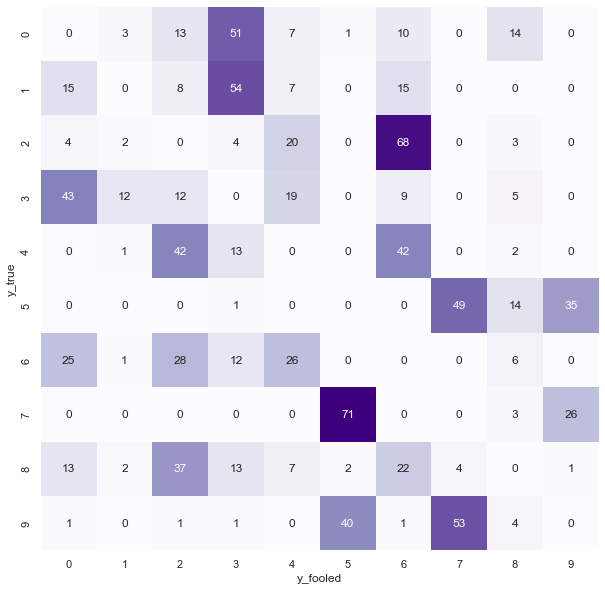

In [39]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(attacktargets, annot=True, ax=ax, cbar=False, cmap="Purples", fmt="g");

In [40]:
natural_targets_dict = {}
non_natural_targets_dict = {}
for ix, series in attacktargets.iterrows():
    natural_targets_dict[ix] = series.argmax()
    non_natural_targets_dict[ix] = series.drop(ix).argmin()

In [41]:
natural_targets_dict

{0: 3, 1: 3, 2: 6, 3: 0, 4: 2, 5: 7, 6: 2, 7: 5, 8: 2, 9: 7}

In [42]:
natural_foolingtargets = np.zeros((y_test.shape[0]))
non_natural_foolingtargets = np.zeros((y_test.shape[0]))

for n in range(len(natural_foolingtargets)):
    target = y_test[n]
    natural_foolingtargets[n] = natural_targets_dict[target]
    non_natural_foolingtargets[n] = non_natural_targets_dict[target]

In [43]:
attack.create_one_hot_targets(natural_foolingtargets.astype(np.int))
attack.attack_to_max_epsilon(targeted_gradient, 30)
natural_scores = attack.scores
attack.create_one_hot_targets(non_natural_foolingtargets.astype(np.int))
attack.attack_to_max_epsilon(targeted_gradient, 30)
non_natural_scores = attack.scores

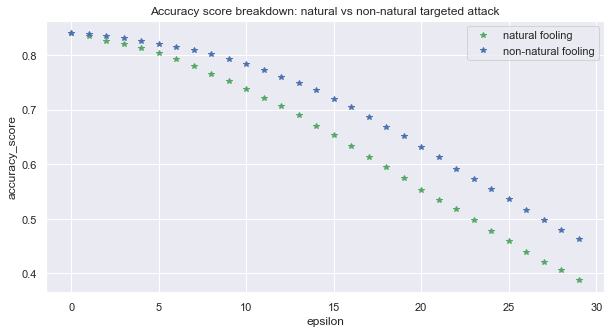

In [44]:
plt.figure(figsize=(10,5))
nf, = plt.plot(attack.epsilons, natural_scores, 'g*', label='natural fooling')
nnf, = plt.plot(attack.epsilons, non_natural_scores, 'b*', label='non-natural fooling')
plt.legend(handles=[nf, nnf])
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown: natural vs non-natural targeted attack');

In [45]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_sign_gradient, 30)

Text(0.5, 1.0, 'Accuracy score breakdown')

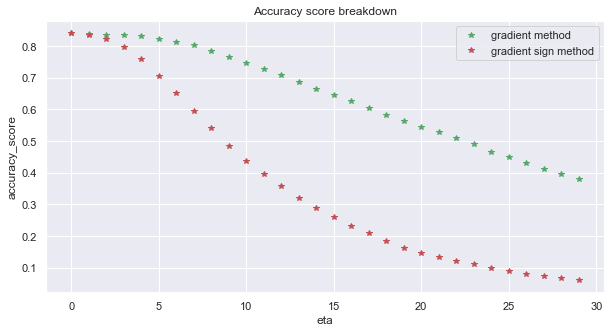

In [46]:
plt.figure(figsize=(10,5))
gm, = plt.plot(attack.epsilons, non_targeted_scores, 'g*', label='gradient method')
gsm, = plt.plot(attack.epsilons, attack.scores, 'r*', label='gradient sign method')
plt.ylabel('accuracy_score')
plt.xlabel('eta')
plt.legend(handles=[gm, gsm])
plt.title('Accuracy score breakdown')